In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, plot_roc_curve
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
merged = pd.read_csv('Cleaned Data/Final/Merge_AllFeatures.csv')
merged.head()

,latitude,lontitude,hour,injury_level,No equipment,Belt,Helmet,Children device,reflective vest,Airbag (2WD / 3WD),...,maneuver_8,maneuver_9,motor_-1,motor_0,motor_1,motor_2,motor_3,motor_4,motor_5,motor_6
0,48.896210,2.470120,1.0,4,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,48.896210,2.470120,1.0,4,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,48.896210,2.470120,1.0,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,48.930700,2.368800,2.0,4,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,48.935872,2.319174,15.0,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [3]:
merged.groupby(['injury_level']).count()

,latitude,lontitude,hour,No equipment,Belt,Helmet,Children device,reflective vest,Airbag (2WD / 3WD),Gloves (2WD / 3WD),...,maneuver_8,maneuver_9,motor_-1,motor_0,motor_1,motor_2,motor_3,motor_4,motor_5,motor_6
injury_level,,,,,,,,,,,,,,,,,,,,,
1,55314,55314,55314,55314,55314,55314,55314,55314,55314,55314,...,55314,55314,55314,55314,55314,55314,55314,55314,55314,55314
2,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498,...,3498,3498,3498,3498,3498,3498,3498,3498,3498,3498
3,20858,20858,20858,20858,20858,20858,20858,20858,20858,20858,...,20858,20858,20858,20858,20858,20858,20858,20858,20858,20858
4,53307,53307,53307,53307,53307,53307,53307,53307,53307,53307,...,53307,53307,53307,53307,53307,53307,53307,53307,53307,53307


Since data is imbalanced, we need to rebalance data, and train, valid and test on the rebalanced data to avoid neglecting class

# Train test split

In [4]:
# Train-test split on oversampled data
features = merged.drop(columns=['injury_level']).columns
X = merged[features]
Y = merged['injury_level']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

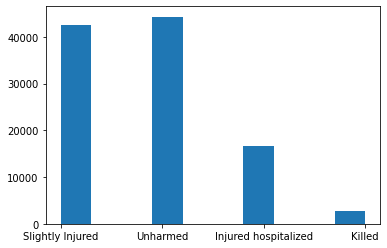

Original training data - imbalanced


In [5]:
# Show original training data - imbalanced
Y_train = Y_train.astype(str)
Y_test = Y_test.astype(str)
ticks = [0, 1, 2, 3]
labels = ['Slightly Injured', 'Unharmed', 'Injured hospitalized', 'Killed']
plt.xticks(ticks, labels)
plt.hist(Y_train)
plt.xticks()
plt.show()
print('Original training data - imbalanced')

# Rebalance Training Data

In [6]:
# Merge X_train, Y_train together
X_Y_train = pd.concat([X_train, Y_train], axis=1)
X_Y_train.head()

,latitude,lontitude,hour,No equipment,Belt,Helmet,Children device,reflective vest,Airbag (2WD / 3WD),Gloves (2WD / 3WD),...,maneuver_9,motor_-1,motor_0,motor_1,motor_2,motor_3,motor_4,motor_5,motor_6,injury_level
108834,48.770690,2.493790,18.0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,4
73816,47.928100,1.924300,14.0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,4
35605,48.455476,-4.626288,11.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
98227,48.697180,2.552190,8.0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,4
36755,44.945420,4.847320,16.0,1,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1


In [7]:
# Count by injury level
injury_1, injury_4, injury_3, injury_2 = X_Y_train['injury_level'].value_counts()
print(injury_1, injury_4, injury_3, injury_2)

44326 42545 16708 2802


In [8]:
injury_1_df = X_Y_train[X_Y_train['injury_level'] == '1']
injury_2_df = X_Y_train[X_Y_train['injury_level'] == '2']
injury_3_df = X_Y_train[X_Y_train['injury_level'] == '3']
injury_4_df = X_Y_train[X_Y_train['injury_level'] == '4']
injury_2_df.shape

(2802, 215)

In [9]:
# Oversampling
injury_2_df_over = injury_2_df.sample(injury_1,random_state=42, replace = True)
injury_4_df_over = injury_4_df.sample(injury_1,random_state=42, replace = True)
injury_3_df_over = injury_3_df.sample(injury_1,random_state=42, replace = True)
merged_over = pd.concat([injury_1_df, injury_2_df_over, injury_3_df_over, injury_4_df_over], axis=0)
merged_over.shape

(177304, 215)

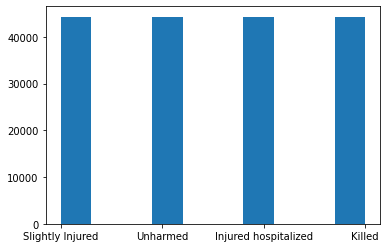

Rebalanced training data


In [10]:
# Show balanced training data
X = merged_over[features]
Y = merged_over['injury_level']
ticks = [0, 1, 2, 3]
labels = ['Slightly Injured', 'Unharmed', 'Injured hospitalized', 'Killed']
plt.xticks(ticks, labels)
plt.hist(Y)
plt.xticks()
plt.show()
print('Rebalanced training data')

# Tree - random forest

**Fit initial random forest**

Rebalanced data

In [11]:
random_forest = RandomForestClassifier(n_estimators=250,random_state=42, max_depth = 13, max_features = 13
                                      ).fit(merged_over[features], merged_over['injury_level']) 
#, max_depth = 30, max_features = 50
# Validate on rebalanced data  - find the hyperparameter that won't overfit
cross_val_score(random_forest, merged_over[features], merged_over['injury_level'], scoring="accuracy", cv=3).mean()

0.7083878450545443

**Find most important features**

Rebalanced data

In [12]:
# Fit model with fewer features
feature_importance_rf = random_forest.feature_importances_
#list(feature_importance_rf)

In [13]:
feature_importance_dict = {}
feature_list = list(features)
for i in range(len(feature_list)):
    feature_importance_dict[feature_list[i]] = list(feature_importance_rf)[i]
#feature_importance_dict

In [14]:
feature_importance_sorted = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1],reverse=True))

**Fit initial random forest**

Rebalanced data, top 50 features

In [15]:
random_forest = RandomForestClassifier(n_estimators=250,random_state=42, max_depth = 13, max_features = 13
                                      ).fit(merged_over[list(feature_importance_sorted.keys())[:50]], merged_over['injury_level'])#merged_over[features], merged_over['injury_level']) 
#, max_depth = 30, max_features = 50
# Validate on rebalanced data  - find the hyperparameter that won't overfit
cross_val_score(random_forest, merged_over[list(feature_importance_sorted.keys())[:50]], merged_over['injury_level'], scoring="accuracy", cv=3).mean()

0.7486802341086781

In [16]:
# Training score on rebalanced data
train_score = random_forest.score(merged_over[list(feature_importance_sorted.keys())[:50]], merged_over['injury_level'])
print(f'The training scroe for rf is {train_score}')

The training scroe for rf is 0.7917926273518928


In [17]:
# Test on original data
print(f'The testing scroe for rf is {random_forest.score(X_test[list(feature_importance_sorted.keys())[:50]], Y_test)}')

The testing scroe for rf is 0.6264475861031734


**Other evaluations on test data**

In [18]:
from sklearn.metrics import confusion_matrix
# Original data Recall and Presicion
mat = confusion_matrix(Y_test, random_forest.predict(X_test[list(feature_importance_sorted.keys())[:50]]))

FP = mat.sum(axis=0) - np.diag(mat)  
FN = mat.sum(axis=1) - np.diag(mat)
TP = np.diag(mat)
TN = mat.sum() - (FP + FN + TP)

#Recall, or true positive rate
TPR = TP/(TP+FN) 
# Precision or positive predictive value
PPV = TP/(TP+FP)

In [19]:
print(merged['injury_level'].unique())
print('4 - Slightly Injured', '1 - Unharmed', '3 - Injured hospitalized', '2 - Killed')
print(f'Precision: {PPV}')
print(f'Recall: {TPR}')

[4 1 3 2]
4 - Slightly Injured 1 - Unharmed 3 - Injured hospitalized 2 - Killed
Precision: [0.72956294 0.18776671 0.40843604 0.71236842]
Recall: [0.78540226 0.37931034 0.56698795 0.50306634]


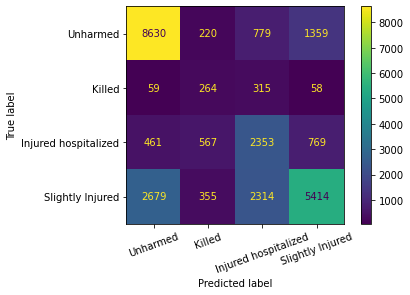

In [20]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(random_forest, X_test[list(feature_importance_sorted.keys())[:50]], Y_test)  
ticks = [0, 1, 2, 3]
labels = ['Unharmed', 'Killed', 'Injured hospitalized', 'Slightly Injured']
plt.xticks(ticks, labels, rotation = 20)
plt.yticks(ticks, labels)
plt.show()

In [21]:
# Area under ROC

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}

    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc


    return roc_auc_dict

print("\nLogistic Regression")
# assuming your already have a list of actual_class and predicted_class from the logistic regression classifier
lr_roc_auc_multiclass = roc_auc_score_multiclass(Y_test, random_forest.predict(X_test[list(feature_importance_sorted.keys())[:50]]))
print(lr_roc_auc_multiclass)


Logistic Regression
{'4': 0.6825044997958635, '2': 0.6676088403674612, '3': 0.7075784452968248, '1': 0.7902216308103318}


**Fairness on gender**

In [23]:
X_Y_test = pd.concat([X_test, Y_test], axis=1)
X_Y_test.head()

,latitude,lontitude,hour,No equipment,Belt,Helmet,Children device,reflective vest,Airbag (2WD / 3WD),Gloves (2WD / 3WD),...,maneuver_9,motor_-1,motor_0,motor_1,motor_2,motor_3,motor_4,motor_5,motor_6,injury_level
27876,48.052962,1.842344,8.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3
91572,44.943290,-0.204690,14.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3
69335,48.849137,2.397031,11.0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
63415,43.511060,5.383580,21.0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,4
72430,47.491740,-0.557050,17.0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3


In [28]:
X_Y_test_M = X_Y_test.loc[X_Y_test['sex_1'] == 1, :]
X_Y_test_M.shape

(18046, 215)

In [29]:
X_Y_test_F = X_Y_test.loc[X_Y_test['sex_2'] == 1, :]
X_Y_test_F.shape

(8550, 215)

In [33]:
X_test_M = X_Y_test_M[features]
Y_test_M = X_Y_test_M['injury_level']
X_test_M.shape

(18046, 214)

In [38]:
X_test_F = X_Y_test_F[features]
Y_test_F = X_Y_test_F['injury_level']
X_test_F.shape

(8550, 214)

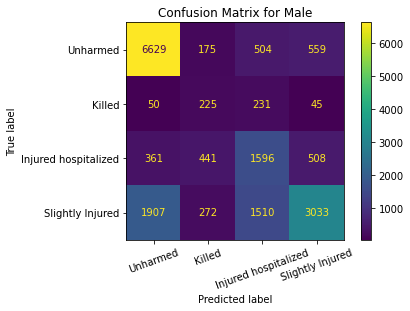

In [36]:
# Plot Confusion Matrix for Male
plot_confusion_matrix(random_forest, X_test_M[list(feature_importance_sorted.keys())[:50]], Y_test_M)  
ticks = [0, 1, 2, 3]
labels = ['Unharmed', 'Killed', 'Injured hospitalized', 'Slightly Injured']
plt.xticks(ticks, labels, rotation = 20)
plt.yticks(ticks, labels)
plt.title('Confusion Matrix for Male')
plt.show()

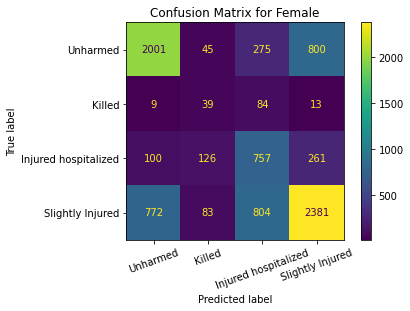

In [39]:
# Plot Confusion Matrix for Female
plot_confusion_matrix(random_forest, X_test_F[list(feature_importance_sorted.keys())[:50]], Y_test_F)  
ticks = [0, 1, 2, 3]
labels = ['Unharmed', 'Killed', 'Injured hospitalized', 'Slightly Injured']
plt.xticks(ticks, labels, rotation = 20)
plt.yticks(ticks, labels)
plt.title('Confusion Matrix for Female')
plt.show()

In [40]:
# Test on original data
print(f'The testing scroe for rf for male is {random_forest.score(X_test_M[list(feature_importance_sorted.keys())[:50]], Y_test_M)}')
print(f'The testing scroe for rf for female is {random_forest.score(X_test_F[list(feature_importance_sorted.keys())[:50]], Y_test_F)}')

The testing scroe for rf for male is 0.6363182976836972
The testing scroe for rf for female is 0.6056140350877193
